<a href="https://colab.research.google.com/github/jkalogero/Neural-Networks/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2020



In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

     |████████████████████████████████| 1.5MB 8.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434679 sha256=5f513b28cdb18f347df5efed649df74b6e47505ecf483015739d98a0d0cc0182
  Stored in directory: /root/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 6.8 MB 9.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [2]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα έχει έναν αριθμό "seed" (φύτρο) που είναι ο ίδιος με τον αριθμό της ομάδας σας: θα τον βρείτε στην κολόνα Α/Α [εδώ](https://docs.google.com/spreadsheets/d/1CD6AtX7YnocXceCELl_XJ06kyRr0YQPhor8dpw012t0/edit?usp=sharing).

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [4]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 67

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [5]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Killer Wave']
['"Disaster",  "Thriller"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

In [14]:
print(corpus_tf_idf.shape)
print(corpus_tf_idf)

(5000, 47943)
  (0, 47172)	0.10636170740253093
  (0, 47001)	0.060664975426296945
  (0, 46984)	0.04450043804022147
  (0, 46745)	0.02515541477638117
  (0, 46664)	0.029662579249770678
  (0, 45925)	0.06543065831693061
  (0, 44984)	0.032445638732630934
  (0, 44884)	0.10347643004790995
  (0, 44155)	0.054874330049076506
  (0, 43669)	0.08061252843604556
  (0, 43495)	0.10918566005071163
  (0, 43201)	0.05291784026897374
  (0, 43167)	0.05688486297522008
  (0, 42818)	0.07367342740946398
  (0, 42711)	0.03548541618735763
  (0, 42705)	0.03058162076023783
  (0, 42689)	0.14582702740060388
  (0, 42019)	0.06156304427775941
  (0, 41615)	0.0826882896413146
  (0, 41599)	0.16221832358962238
  (0, 40912)	0.10636170740253093
  (0, 39812)	0.10099516851967422
  (0, 39521)	0.04234020828274772
  (0, 39324)	0.12485114300372406
  (0, 39281)	0.07908819131303647
  :	:
  (4999, 9355)	0.11460429278874149
  (4999, 8964)	0.1000821731156816
  (4999, 8869)	0.0865397562820995
  (4999, 8583)	0.08145091794457572
  (4999, 6490)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing) των ασκήσεων.


Αρχικά κατασκευάζουμε συνάρτηση που θα χρησιμοποιεί την TfidfVectorizer με παραμέτρους που θα δίνονται κατά την κλήση της:

In [203]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_english
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(max_df=1.0, min_df=0, stop_words=list()):
    # common english words that will also be ignored
    common_english_stop_words = list(stopwords_english)
    final_stop_words = stop_words + common_english_stop_words
    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, stop_words = final_stop_words)
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus)

    # print shape
    print(max_df)
    print(corpus_tf_idf.shape)
    # print result
    # print(corpus_tf_idf)

    return corpus_tf_idf

corpus_tf_idf = tf_idf()

1.0
(5000, 47637)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [66]:
def print_movie_info(target_movie):
    print("Movie ID: ", target_movie)
    print("Movie title: ", titles[target_movie])
    print("Movie plot: ", corpus[target_movie])
    print("Movie categories: ", categories[target_movie])
    print("="*600)


print_movie_info(0)

Movie ID:  0
Movie title:  ['Paradise Murdered']
Movie plot:  Off the southern coast of the Korean Peninsula, an island of 17 inhabitants exists. The so-called Paradise Island holds up to its name with its breath-taking mountains and sea coupled with good-natured people. No worries or stress holds for anyone who comes to visit this beautiful oasis. But this peace doesn’t last long as every single one of the inhabitants disappear one day without a single trace. Chaos initially breaks out when a blood-drenched corpse is found and everyone becomes a suspect. The furious sea allows them no boat ride to the mainland and their only existing radio communication device has been smashed. Trapped together on the island, everyone is suspicious of each other and even the unseen could be a possible suspect. As hideous secrets get revealed day by day, an island of paradise slowly turns into an island of death.
Movie categories:  ['"Thriller",  "Mystery"']


In [124]:
# import scipy as sp
from sklearn.metrics.pairwise import linear_kernel

def content_recommender(target_movie, max_recommendations):
    sorted_corpus = sorted(range(corpus_tf_idf.shape[0]), reverse=True, key=lambda k: linear_kernel(corpus_tf_idf[target_movie], corpus_tf_idf[k]))

    # print target movie info
    print('\033[1m','\033[36m',"Target Movie", '\033[0m')
    print_movie_info(target_movie)

    for index, movie in enumerate(sorted_corpus[1:max_recommendations+1]):
        print('\033[1m','\033[36m',index+1, "position", '\033[0m')
        print_movie_info(movie)


content_recommender(0, 5)

  Target Movie 
Movie ID:  0
Movie title:  ['Paradise Murdered']
Movie plot:  Off the southern coast of the Korean Peninsula, an island of 17 inhabitants exists. The so-called Paradise Island holds up to its name with its breath-taking mountains and sea coupled with good-natured people. No worries or stress holds for anyone who comes to visit this beautiful oasis. But this peace doesn’t last long as every single one of the inhabitants disappear one day without a single trace. Chaos initially breaks out when a blood-drenched corpse is found and everyone becomes a suspect. The furious sea allows them no boat ride to the mainland and their only existing radio communication device has been smashed. Trapped together on the island, everyone is suspicious of each other and even the unseen could be a possible suspect. As hideous secrets get revealed day by day, an island of paradise slowly turns into an island of death.
Movie categories:  ['"Thriller",  "Mystery"']
  1 position 
Movie ID:  398

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Σαν πρώτο βήμα για την βελτιστοποίηση της συνάρτησης *tf_idf* είναι ο εμπλουτισμός των stop words. Συγκεκριμένα, μέχρι στιγμής το σύνολο των stopwords περιλαμβάνει μόνο την συνήθεις αγγλικές λέξεις. Επιπλέον σε αυτές θα προσθέσουμε λέξεις που συνδέονται με τον κινηματογράφο και εμφανίζονται συχνά στις πλοκές των ταινιών, καθώς και ένα σύνολο από τα αγγλικά ονόματα, ώστε να αγνοούνται.

Επομένως, έχουμε βρει ανάμεσα σε 100 τυχαίες ταινίες ποια αυτές με τ

In [ ]:
import urllib.request 
import string

# words used commonly in film plots, hence will be ignored
film_stop_words = ["movie", "starring", "actor", "actress", "film", "plot", "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping"]

# english names
female_names_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt"
male_names_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt"

names = []
for url in [female_names_url, male_names_url]:
    response = urllib.request.urlopen(url).read().decode()
    names = names + [name.lower() for name in response.split('\n') if name and name[0] != "#"]

stop_words = film_stop_words + names
print(len(stop_words))

corpus_tf_idf = tf_idf(stop_words=stop_words)
print(corpus_tf_idf.shape)
content_recommender(4800, 2)

In [103]:
content_recommender(666, 3)

  Target Movie 
Movie ID:  666
Movie title:  ['Shadow on the Wall']
Movie plot:  Child Susan Starrling  is the sole witness to a killing, but the shock causes her to suffer amnesia about the event. Her father David  is convicted of first degree murder of his wife. However, psychiatrist Caroline Cranford  is convinced she can cure the young girl and begins to suspect that another person is guilty.
Movie categories:  ['"Mystery",  "Film noir",  "Psychological thriller",  "Black-and-white"']
  1 position 
Movie ID:  4027
Movie title:  ['Eyes Beyond Seeing']
Movie plot:  An enigmatic, homeless mental patient  who claims to be the second coming of Jesus Christ has recently been once again committed. He begins to suffer asylum life. Despite this, he befriends his psychiatrist who has lost his faith, and the man manages to change the psychiatrist's life.
Movie categories:  ['"Drama"']
  2 position 
Movie ID:  4628
Movie title:  ['Steamboat Round the Bend']
Movie plot:  A con man enters his st

Ως μία μετρική για το για ποια ταινία προτάθηκαν οι σχετικότερες με αυτήν ταινίες, θεωρούμε το πλήθος των κατηγοριών αυτής που αποτελούν κατηγορίες και για τις προτεινόμενες για αυτήν ταινίες. 

Επομένως, για την κάθε ταινία που εξετάζουμε βρίσκουμε της 3 πιο κοντινές, με βάση το $cosine similarity$ και στη συνέχεια για καθεμία από τις 3 ταινίες υπολογίζουμε το:

**πλήθος κοινών κατηγοριών με την target movie δια πλήθος κατηγοριών της target movie**

Στη συνέχεια υπολογίζουμε τον μέσο όρο του παραπάνω κλάσματος και για τις 3 ταινίες που προτάθηκαν και επαναλαμβάνουμε για κάθε ταινία που εξετάζουμε.

Στο τέλος ταξινομούμε τις ταινίες με βάση τον μέσο όρο των κλασμάτων. Η βελτιστο



In [133]:
from IPython.display import HTML, display
import time

def progress(value, max=50):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [152]:
import random

def similar_categories(max_recommendations, movies_to_check=range(len(titles))):
    best_movies = []
    
    # cnt for progress bar
    cnt = 0
    # for every movie
    out = display(progress(0, len(movies_to_check)), display_id=True)
    for movie in movies_to_check:
        cnt += 1
        # get sorted array of indexes accoring to the cosine similarity
        cosine_similarity_sorted = sorted(range(corpus_tf_idf.shape[0]), reverse=True, key=lambda k: linear_kernel(corpus_tf_idf[movie], corpus_tf_idf[k]))
        movie_categories = set([cat[1:-1] for cat in categories[movie][0].split(',  ')])
        sum = 0
        for similar_movie in cosine_similarity_sorted[1:max_recommendations+1]:
            similar_movie_categories = set([cat[1:-1] for cat in categories[similar_movie][0].split(',  ')])
            sum += len(movie_categories.intersection(similar_movie_categories)) / len(movie_categories)
        mean = sum / max_recommendations
        best_movies.append((movie, mean))
        out.update(progress(cnt, len(movies_to_check)))

    # sort
    best_movies.sort(key=lambda tup: tup[1], reverse=True)
    # progress bar
    return best_movies

# get 100 random movies from our list
hundred_random_movies = [i for i in random.sample(range(0,5001), 100)]

best_movies = similar_categories(max_recommendations=3, movies_to_check=hundred_random_movies)

In [163]:
from google.colab import files
# download best_movies variable 
!echo '$best_movies' > best_movies
files.download('best_movies')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Επιλέγοντας τις 8 πρώτες ταινίες που είχαν το καλύτερο ποσοστό κατηγοριών στις προτεινόμενες για αυτές ταινίες έχουμε:

In [170]:
print(best_movies[:10])
movies_for_opt = [movie[0] for movie in best_movies[:10]]

[(3516, 0.8571428571428571), (1053, 0.6666666666666666), (802, 0.6666666666666666), (2744, 0.6666666666666666), (4723, 0.6666666666666666), (3145, 0.6666666666666666), (4054, 0.6666666666666666), (4976, 0.6666666666666666), (833, 0.6666666666666666), (2704, 0.6666666666666666)]


In [173]:
corpus_tf_idf = tf_idf(stop_words=stop_words)
content_recommender(3516, 10)
similar_categories(max_recommendations=10, movies_to_check=[3516])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(5000, 44635)
  Target Movie 
Movie ID:  3516
Movie title:  ['Godzilla: Final Wars']
Movie plot:   Endless warfare and environmental pollution has resulted in dangerous kaiju and the Earth Defense Force  is created to protect the planet. The organization is equipped with the best technology, weapons and soldiers, as well as mutants with special abilities. Godzilla is the EDF's only unstoppable opponent. The EDF's best combat vehicle, the Gotengo, corners Godzilla at the South Pole and buries him under the Antarctic ice, freezing him alive. Several years later, the EDF discovers a mummified space monster. Mutant soldier Shinichi Ozaki and United Nations biologist Dr. Miyuki Otonashi are sent to research it. Shortly thereafter, the two encounter the Shobijin, fairies of the guardian monster Mothra, who reveal that the monster is Gigan, an alien cyborg sent to destroy Earth 12,000 years earlier. They also warn that a battle between good and evil will happen soon. Monsters appear in major 

[(3516, 0.41428571428571426)]

Παρατηρούμε ότι οι περισσότερες από τις 10 ταινίες που προτάθηκαν ανήκουν στην κατηγορία *Science Fiction*. Ωστόσο, παρατηρούμε ότι το ποσοστό των κατηγοριών της target movie που ανήκουν και σε αυτές που προτάθηκαν είναι μειωμένο (41.4% έναντι 85.7%). Αυτό είναι λογικό, αφού αφενός έχουμε πλέον μεγαλυτερο δείγμα ταινιών και αφετέρου οι πρώτες ταινίες που προτάθηκαν ανήκουν στην ίδια σειρά ταινιών. Αξίζει ωστόσο να σημειώσουμε ότι το ποσοστό αυτό δεν είναι πολύ μακριά από το 2ο καλύτερο ποσοστό όταν προτείναμε 3 μόνο ταινίες (66.6%).

### Max_df

Στη συνέχεια, θα πειραματιστούμε με την μείωση της διαστατικότητας αφαιρώντας λέξεις που εμφανίζονται αρκετά συχνά. Η default παράμετρος που έχει χρησιμοποιποιηθεί μέχρι στιγμής είναι 1.0, που δηλώνει ότι θα αγνοούνται οι λέξεις που εμφάνίζονται σε κάθε κείμενο (πλοκή της κάθε ταινίας). Επομένως, θα δοκιμάσουμε να μειώσουμε το κατώφλι πάνω από το οποίο οι λέξεις θα αγνοούνται:

In [221]:
max_dfs = [0.001, 0.01, 0.1, 0.9, 1.0]
max_df_scores = []
for max_df in max_dfs:
    print("\t\t",'\033[1m',"max_df = ",max_df,'\033[0m')
    corpus_tf_idf = tf_idf(max_df=max_df, stop_words=stop_words)
    content_recommender(1053, 20)
    max_df_scores.append(similar_categories(max_recommendations=20, movies_to_check=[1053]))

		  max_df =  0.001 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.001
(5000, 34156)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  4988
Movie title:  ['

		  max_df =  0.01 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.01
(5000, 42619)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['K

		  max_df =  0.1 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.1
(5000, 44544)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

		  max_df =  0.9 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.9
(5000, 44635)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

		  max_df =  1.0 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 44635)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

In [222]:
print(max_df_scores)

[[(1053, 0.0)], [(1053, 0.3)], [(1053, 0.3)], [(1053, 0.3)], [(1053, 0.3)]]


### Min_df

In [253]:
min_dfs = [1,2,3,4,5]
min_df_scores = []
for min_df in min_dfs:
    print("\t\t",'\033[1m',"min_df = ",min_df,'\033[0m')
    corpus_tf_idf = tf_idf(min_df=min_df, stop_words=stop_words)
    content_recommender(1053, 10)
    min_df_scores.append(similar_categories(max_recommendations=10, movies_to_check=[1053]))

		  min_df =  1 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 44635)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

		  min_df =  2 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 22150)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2483
Movie title:  ['Ye

		  min_df =  3 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 16584)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2483
Movie title:  ['Ye

		  min_df =  4 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 13677)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

		  min_df =  5 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1.0
(5000, 11821)
  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2678
Movie title:  ['Ke

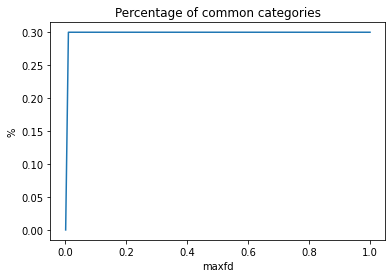

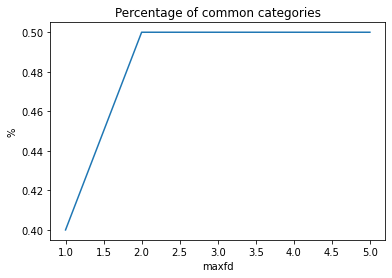

In [254]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotScores(xaxis, yaxis):
    plt.plot(xaxis,yaxis)
    plt.xlabel('maxfd')
    plt.ylabel('%')
    
    plt.title('Percentage of common categories')
    
    plt.show()


max_scores = [score[0][1] for score in max_df_scores]
min_scores = [score[0][1] for score in min_df_scores]
plotScores(max_dfs, max_scores)
plotScores(min_dfs, min_scores)

## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [ ]:
final_set.shape

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">




## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο eclass το παρόν notebook επεξεργασμένο ή ένα νέο με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.
- Στο **zip** που θα παραδώσετε πρέπει να βρίσκονται **2 αρχεία (το .ipynb και το .py του notebook σας)**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!</font>
</td>
  </tr>
</table>